In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, roc_curve, auc
import numpy as np
import os



In [15]:


########################################
# 1. Hyperparameters
########################################
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 2
NUM_CLASSES = 20   # Pascal VOC has 20 classes

########################################
# 2. Transforms
########################################
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize for ResNet50
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

########################################
# 3. Multi-label target encoding
########################################
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
    'tvmonitor'
]

def encode_voc_target(target):
    """Converts VOC annotation to multi-hot vector for 20 classes"""
    objects = target['annotation'].get('object', [])
    if not isinstance(objects, list):
        objects = [objects]  # single object case
    labels = [0] * NUM_CLASSES
    for obj in objects:
        if obj['name'] in VOC_CLASSES:
            idx = VOC_CLASSES.index(obj['name'])
            labels[idx] = 1
    return torch.tensor(labels, dtype=torch.float32)

########################################
# 4. Dataset & Dataloader
########################################
repo_root = "C:/Users/kamed/Desktop/argonne_K/pascal-voc-project"
voc_root = os.path.join(repo_root, "VOCdevkit")  # parent of VOC2012

train_dataset = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="train",
    download=False,
    transform=transform,
    target_transform=encode_voc_target
)

val_dataset = torchvision.datasets.VOCDetection(
    root=repo_root,
    year="2012",
    image_set="val",
    download=False,
    transform=transform,
    target_transform=encode_voc_target
)

# Only use first 200 images for CPU testing
#train_dataset = torch.utils.data.Subset(train_dataset, list(range(200)))
#val_dataset = torch.utils.data.Subset(val_dataset, list(range(50)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

In [16]:
########################################
# 4. Model (ResNet50 with transfer learning)
########################################

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, NUM_CLASSES),
    nn.Sigmoid()
)

device = torch.device("cpu")  # force CPU
model = model.to(device)
print("model ready")
'''
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False   # freeze feature extractor

# Replace final layer for 20-class multi-label classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, NUM_CLASSES),
    nn.Sigmoid()   # since multi-label, we need sigmoid not softmax
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
'''

model ready


'\nmodel = models.resnet50(pretrained=True)\nfor param in model.parameters():\n    param.requires_grad = False   # freeze feature extractor\n\n# Replace final layer for 20-class multi-label classification\nmodel.fc = nn.Sequential(\n    nn.Linear(model.fc.in_features, NUM_CLASSES),\n    nn.Sigmoid()   # since multi-label, we need sigmoid not softmax\n)\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = model.to(device)\n'

In [17]:
########################################
# 5. Loss & Optimizer
########################################
criterion = nn.BCELoss()  # binary cross entropy for multi-label
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

########################################
# 6. Training Loop
########################################
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, targets in loader:
        images, targets = images.to(device), targets.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

########################################
# 7. Validation (ROC, Confusion Matrix)
########################################
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.float().to(device)
            outputs = model(images)
            y_true.append(targets.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    # ROC AUC (macro average)
    roc_auc = roc_auc_score(y_true, y_pred, average="macro")

    # Confusion matrix (per class, threshold at 0.5)
    y_pred_binary = (y_pred > 0.5).astype(int)
    cm = multilabel_confusion_matrix(y_true, y_pred_binary)

    return roc_auc, cm, y_true, y_pred


In [18]:
########################################
# 8. Run Training
########################################
for epoch in range(EPOCHS):
    loss = train_one_epoch(model, train_loader, optimizer, criterion)
    roc_auc, cm, y_true, y_pred = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f} - Val ROC AUC: {roc_auc:.4f}")

Epoch 1/2 - Loss: 0.1607 - Val ROC AUC: 0.9571
Epoch 2/2 - Loss: 0.1237 - Val ROC AUC: 0.9602


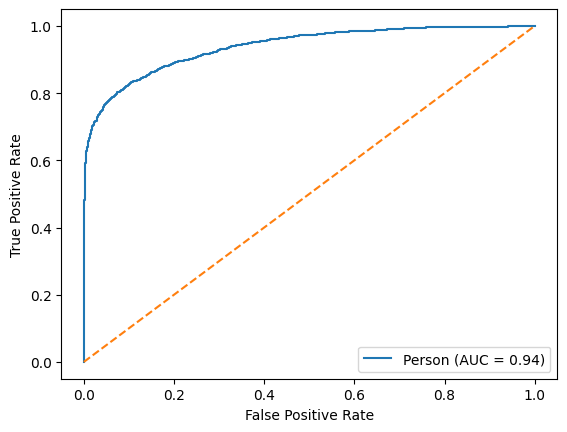

In [19]:
########################################
# 9. Plot ROC Curve for one class (example: 'person')
########################################
cls_idx = 14  # index of 'person'
fpr, tpr, _ = roc_curve(y_true[:, cls_idx], y_pred[:, cls_idx])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Person (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()